In [1]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import matplotlib.pyplot as plt
import random
import time
from pprint import pprint
from rdflib import Graph
%matplotlib inline

In [2]:
prefix = "PREFIX : <http://data.krw.d2s.labs.vu.nl/group10/vocab/>"
TUTORIAL_REPOSITORY = "http://stardog.krw.d2s.labs.vu.nl/group10"
endpoint = TUTORIAL_REPOSITORY + "/query"

In [3]:
def clearStardog():
    """Careful! This one clears the entire stardog repository specified in TUTORIAL_REPOSITORY"""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/clear"
    response = requests.post(post_url, headers={'Accept': 'text/plain'})
    
    print "Sent clear request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def upload_file_to_stardog(filename, mimetype='application/trig'):
    """Well, obvious what this does... you can set the 'mimetype' to e.g. text/turtle if you want to upload a turtle file"""
    with open(filename,'r') as f:
        data = f.read()
        
    upload_to_stardog(data, mimetype=mimetype)
    
    return
    
#was eerst (data, mimetype=application/trig)
def upload_to_stardog(data, mimetype='application/n-triples'):
    """Upload data to Stardog, you know this one from the previous assignments..."""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    #print "Transaction id: {}".format(transaction_id)
    
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/add"
    response = requests.post(post_url, data=data, headers={'Accept': 'text/plain', 'Content-type': mimetype}, stream=True)

    #print "Sent add request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    #print "Closing transaction: {}".format(response.status_code)
    
    return

    
def getClasses(reasoning='true', max=None):
    """Get all classes from the repo, optionally with a limit of `max`"""
    if max is None :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class }"""
    else :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class } LIMIT """ + str(max)
    
    return [r['c']['value'] for r in runQuery(query, reasoning)]
    

def getInstances(className, reasoning='true'):
    """Get the instances for a class.. be sure to include < and > around its URI"""
    query = prefix + """
    SELECT ?i WHERE {{?i a {} . }}
    """.format(className)
    
    return [r['i']['value'] for r in runQuery(query, reasoning)]

def countUsage(reasoning='true', max=None):
    """Count the number of occurrences of a resource. Will differ significantly if reasoning is 'false'"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'resource' in r:
            index[unicode(r['resource']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def countClassUsage(reasoning, max=None):
    """Count how many (inferred) instances a class has"""
    query = """
        SELECT ?class (COUNT(?resource) as ?count) WHERE {
            ?resource a ?class . 
        } GROUP BY ?class ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'class' in r:
            index[unicode(r['class']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index

def countUsageLocal(rdfgraph, max=None):
    """Count usage of a resource on a local RDFLib graph"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY ?resource
    """
    
    results = rdfgraph.query(query)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
            
        index[unicode(r['resource'])] = int(r['count'])
        
        count += 1
    
    return index
    

def runQuery(query, reasoning='true'):
    """Run a SPARQL query against the endpoint"""
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    sparql.addParameter('Accept','application/sparql-results+json')

    sparql.addParameter('reasoning',reasoning)

    response = sparql.query().convert()

    return response['results']['bindings']

def buildNetwork(rdfgraph, query = """SELECT * WHERE {?source ?edge ?target.}""", max=None):
    ## Query is assumed to have a source, target and edge
    
    results = rdfgraph.query(query)
    
    G = nx.DiGraph()
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        G.add_edge(r['source'], r['target'], {'type': r['edge']})
        
        count += 1
        
    return G

In [8]:
g = Graph()

g += g.parse('dataset.nt',format='nt')

clearStardog()
upload_file_to_stardog('dataset.nt')

Transaction id: 38aac56e-7648-4975-bea6-09a05e843cb9
Sent clear request: 200
Closing transaction: 200


In [9]:
G = buildNetwork(g, max=10000)

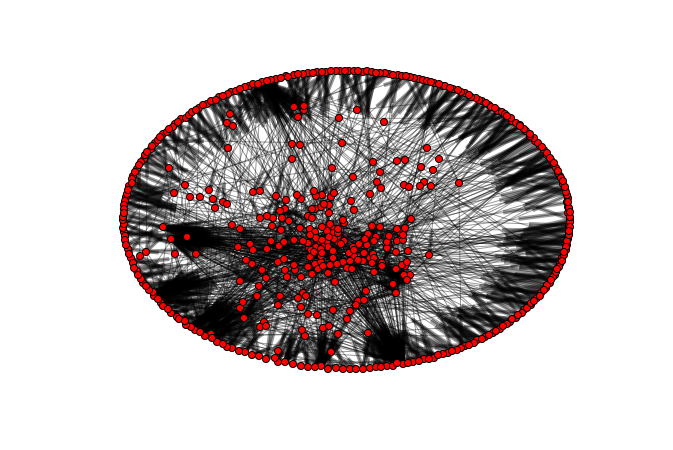

In [10]:
# draw graph in inset
plt.axes([1.45,1.45,1.45,1.45])
pos=nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_size=50)
nx.draw_networkx_edges(G,pos,alpha=0.4)
plt.show()

In [133]:
print("Graph has %s statements." % len(g))
#print(sorted(g))

Graph has 1276 statements.


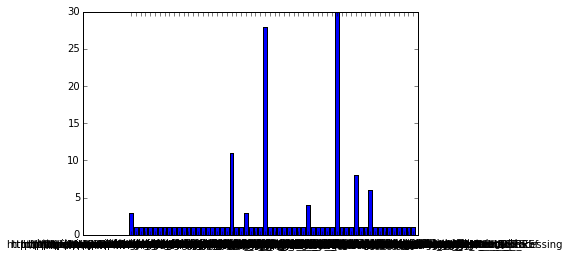

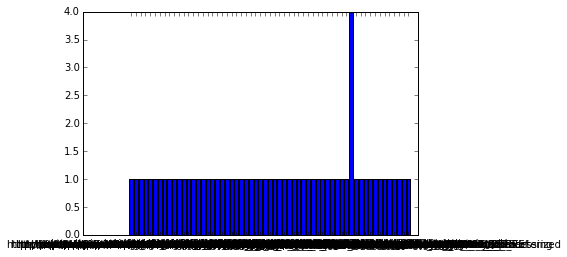

In [13]:
total_true = countClassUsage('true')
total_false = countClassUsage('false')


total_true_filtered = {}
total_false_filtered = {}
for key in total_true:
    if 'www.w3.org' not in key:
        values = total_true.get(key)
        if values != None:
            total_true_filtered.update({key:values})
for key in total_false:
    if 'www.w3.org' not in key:
        values = total_false.get(key)
        if values != None:
            total_false_filtered.update({key:values})


plt.bar(range(len(total_true_filtered)), total_true_filtered.values(), align='center')
plt.xticks(range(len(total_true_filtered)), total_true_filtered.keys())
plt.show()

plt.bar(range(len(total_false_filtered)), total_false_filtered.values(), align='center')
plt.xticks(range(len(total_false_filtered)), total_false_filtered.keys())
plt.show()

Random Buckets: 

In [14]:
#random buckets,order based on numbers of buckets
bucket_1_random = Graph()
bucket_2_random = Graph()
bucket_3_random = Graph()
bucket_4_random = Graph()
bucket_5_random = Graph()
bucket_list_random = [bucket_1_random,bucket_2_random,bucket_3_random,bucket_4_random,bucket_5_random]

for s,p,o in g:
    selected_bucket = random.choice(bucket_list_random)
    while len(selected_bucket) > 256:
        selected_bucket = random.choice(bucket_list_random)
    selected_bucket.add((s,p,o))

#for s,p,o in bucket_1:
#    print s,p,o 
#print len(bucket_1)

Buckets based on in-degree and out-degree

In [15]:
#buckets based on indegree
#networkX: degree = The node degree is the number of edges adjacent to that node.
#networkX: in-degree = The node in-degree is the number of edges pointing in to the node.
#networkX: out-degree = The node out-degree is the number of edges pointing out of the node.
indegree = G.in_degree()
#indegree

outdegree= G.out_degree()
# outdegree


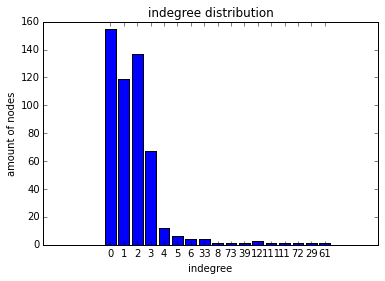

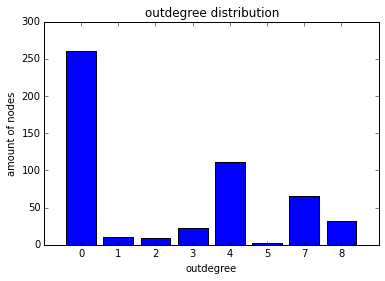

In [141]:
#plot results as histogram
import collections

indegree_values = list(G.in_degree().values())
#indegree_values

counter_in=collections.Counter(indegree_values)

##########################################################
# or for outdegree: 
outdegree_values = list(G.out_degree().values())
counter_out=collections.Counter(outdegree_values)

#########################################################

plt.bar(range(len(counter_in)), counter_in.values(), align='center')
plt.title('indegree distribution')
plt.xlabel('indegree')
plt.ylabel('amount of nodes')
plt.xticks(range(len(counter_in)), counter_in.keys())
plt.show()

plt.bar(range(len(counter_out)), counter_out.values(), align='center')
plt.xticks(range(len(counter_out)), counter_out.keys())
plt.title('outdegree distribution')
plt.xlabel('outdegree')
plt.ylabel('amount of nodes')
plt.show()

In [115]:
#in-degree buckets
bucket_1_in = Graph()  #values > 12
bucket_2_in = Graph()  #values > 6
bucket_3_in = Graph()  #values 4,5,6
bucket_4_in = Graph()  #values 2 and 3
bucket_5_in = Graph()  #values 0 and 1

bucket_list_in = [bucket_1_in,bucket_2_in,bucket_3_in,bucket_4_in,bucket_5_in]

bucket_1_out = Graph()  #values 8 
bucket_2_out = Graph()  #values 5+7
bucket_3_out = Graph()  #values 4
bucket_4_out = Graph()  #values 1+2+3
bucket_5_out = Graph()  #values 0

bucket_list_out = [bucket_1_out,bucket_2_out,bucket_3_out,bucket_4_out,bucket_5_out]

for s,p,o in g:
    if s in indegree.keys():
        value_s_in = indegree.get(s)
        
        if value_s_in == 0 or value_s_in == 1 : 
            selected_bucket1_in = bucket_5_in
        if value_s_in == 2 or value_s_in == 3 : 
            selected_bucket1_in = bucket_4_in
        if value_s_in == 4 or value_s_in == 5 or value_s_in == 6 :
            selected_bucket1_in = bucket_3_in 
        if value_s_in > 6 and value_s_in < 13 : 
            selected_bucket1_in = bucket_2_in  
        if value_s_in > 12 : 
            selected_bucket1_in = bucket_1_in
        
        
        selected_bucket1_in.add((s,p,o))
        
    if s in outdegree.keys():
        
        value_s_out = outdegree.get(s)        
        if value_s_out == 0: 
            selected_bucket1_out = bucket_5_out
        if value_s_out == 1 or value_s_out == 2 or value_s_out == 3 : 
            selected_bucket1_out = bucket_4_out
        if value_s_out == 4:
            selected_bucket1_out = bucket_3_out 
        if value_s_out > 4 and value_s_out < 8 : 
            selected_bucket1_out = bucket_2_out  
        if value_s_out > 7 : 
            selected_bucket1_out = bucket_1_out
        
        selected_bucket1_out.add((s,p,o))
    
    if o in indegree.keys():
        value_o_in = indegree.get(o)
        
        if value_o_in == 0 or value_o_in == 1 : 
            selected_bucket2_in = bucket_5_in
        if value_o_in == 2 or value_o_in == 3 : 
            selected_bucket2_in = bucket_4_in
        if value_o_in == 4 or value_o_in == 5 or value_o_in == 6 :
            selected_bucket2_in = bucket_3_in 
        if value_o_in > 6 and value_o_in < 13 : 
            selected_bucket2_in = bucket_2_in  
        if value_o_in > 12 : 
            selected_bucket2_in = bucket_1_in
        
        selected_bucket2_in.add((s,p,o))
        
    if o in outdegree.keys():
        
        value_o_out = outdegree.get(o)        
        if value_o_out == 0: 
            selected_bucket2_out = bucket_5_out
        if value_o_out == 1 or value_o_out == 2 or value_o_out == 3 : 
            selected_bucket2_out = bucket_4_out
        if value_o_out == 4:
            selected_bucket2_out = bucket_3_out 
        if value_o_out > 4 and value_o_out < 8 : 
            selected_bucket2_out = bucket_2_out  
        if value_o_out > 7 : 
            selected_bucket2_out = bucket_1_out
        
        selected_bucket2_out.add((s,p,o))



In [116]:
def filter_bucket(results):
    bucket_1_filtered = {}
    for i in range(len(results)):
        for bucket in results[i]:
            for key in results[i][bucket]:
                if 'www.w3.org' not in key:
                    values = results[i][bucket][key]
                    if values != None:
                        bucket_1_filtered.update({key:values})
    return bucket_1_filtered

def recall(bucket_set, total_true_set):
    all_p = 0.0
    for key in total_true_set:
        all_p += total_true_set[key]
    tp = 0.0
    for key in bucket_set:
        tp += bucket_set[key]

    return tp / all_p


In [117]:
#dicts
results_random_true = []
results_random_false = []
results_in_true = []
results_in_false = []
results_out_true = []
results_out_false = []
#recall scores
recall_random_true = []
recall_random_false = []
recall_in_true = []
recall_in_false = []
recall_out_true = []
recall_out_false = []
#time scores
time_random_true = []
time_random_false = []
time_in_true = []
time_in_false = []
time_out_true = []
time_out_false = []

#random buckets
i=1
clearStardog()
for bucket in bucket_list_random:
    #put the bucket in stardog
    nt_format = bucket.serialize(format='nt')
    upload_to_stardog(nt_format)
    #get results
    name='bucket_'+str(i)+'_random'
    start_time_true = time.time()
    results_random_true.append({name:countClassUsage('true')})
    end_time_true = time.time()
    start_time_false = time.time()
    results_random_false.append({name:countClassUsage('false')})
    end_time_false = time.time()
    time_random_true.append(end_time_true-start_time_true) 
    time_random_false.append(end_time_false-start_time_false)
    recall_random_true.append(recall(filter_bucket(results_random_true), total_true_filtered))
    recall_random_false.append(recall(filter_bucket(results_random_false), total_false_filtered))
    i+=1


Transaction id: 0f55abfc-f117-4bf0-8464-8299f36f0591
Sent clear request: 200
Closing transaction: 200


In [118]:
#indegree buckets
i=1
clearStardog()
for bucket in bucket_list_in:
    #put the bucket in stardog
    nt_format = bucket.serialize(format='nt')
    upload_to_stardog(nt_format)
    #get results
    name='bucket_'+str(i)+'_in'
    start_time_true = time.time()
    results_in_true.append({name:countClassUsage('true')})
    end_time_true = time.time()
    start_time_false = time.time()
    results_in_false.append({name:countClassUsage('false')})
    end_time_false = time.time()
    time_in_true.append(end_time_true-start_time_true) 
    time_in_false.append(end_time_false-start_time_false)
    recall_in_true.append(recall(filter_bucket(results_in_true), total_true_filtered))
    recall_in_false.append(recall(filter_bucket(results_in_false), total_false_filtered))
    i+=1

Transaction id: 4fed70af-ea16-48d2-bfa6-3d85a7344a11
Sent clear request: 200
Closing transaction: 200


In [119]:
bucket_list_in_reverse = [bucket_5_in,bucket_4_in,bucket_3_in,bucket_2_in,bucket_1_in]

results_in_true_reverse = []
results_in_false_reverse = []
recall_in_true_reverse = []
recall_in_false_reverse = []

#indegree buckets reverse
i=5
clearStardog()
for bucket in bucket_list_in_reverse:
    #put the bucket in stardog
    nt_format = bucket.serialize(format='nt')
    upload_to_stardog(nt_format)
    #get results
    name='bucket_'+str(i)+'_in'
    results_in_true_reverse.append({name:countClassUsage('true')})
    results_in_false_reverse.append({name:countClassUsage('false')})
    recall_in_true_reverse.append(recall(filter_bucket(results_in_true_reverse), total_true_filtered))
    recall_in_false_reverse.append(recall(filter_bucket(results_in_false), total_false_filtered))
    i-=1

Transaction id: 729d3a7e-5ab0-400c-8611-c5b209bf0477
Sent clear request: 200
Closing transaction: 200


In [121]:
#outdegree buckets
i=1
clearStardog()
for bucket in bucket_list_out:
    #put the bucket in stardog
    nt_format = bucket.serialize(format='nt')
    upload_to_stardog(nt_format)
    #get results
    name='bucket_'+str(i)+'_out'
    start_time_true = time.time()
    results_out_true.append({name:countClassUsage('true')})
    end_time_true = time.time()
    start_time_false = time.time()
    results_out_false.append({name:countClassUsage('false')})
    end_time_false = time.time()
    time_out_true.append(end_time_true-start_time_true) 
    time_out_false.append(end_time_false-start_time_false)
    recall_out_true.append(recall(filter_bucket(results_out_true), total_true_filtered))
    recall_out_false.append(recall(filter_bucket(results_out_false), total_false_filtered))
    i+=1

Transaction id: 56e28abc-af1b-470a-b7ed-e47e8d49ba98
Sent clear request: 200
Closing transaction: 200


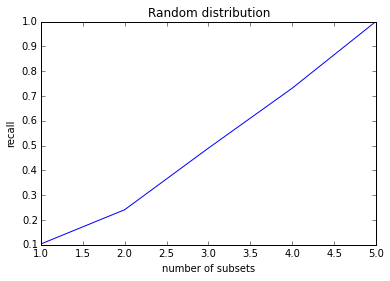

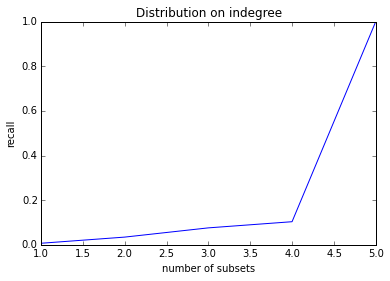

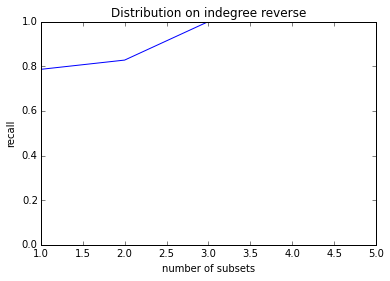

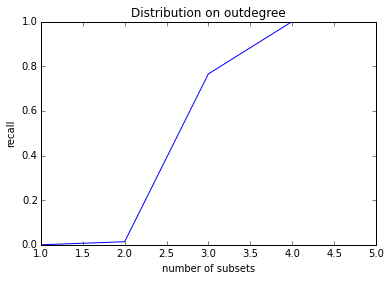

In [130]:
#recall plot
plt.plot([1,2,3,4,5], recall_random_true)
plt.title('Random distribution')
plt.xlabel('number of subsets')
plt.ylabel('recall')
plt.show()

plt.plot([1,2,3,4,5], recall_in_true)
plt.title('Distribution on indegree')
plt.xlabel('number of subsets')
plt.ylabel('recall')
plt.show()

plt.plot([1,2,3,4,5], recall_in_true_reverse)
plt.title('Distribution on indegree reverse')
plt.xlabel('number of subsets')
plt.ylabel('recall')
plt.ylim([0,1.0])
plt.show()

plt.plot([1,2,3,4,5], recall_out_true)
plt.title('Distribution on outdegree')
plt.xlabel('number of subsets')
plt.ylabel('recall')
plt.show()


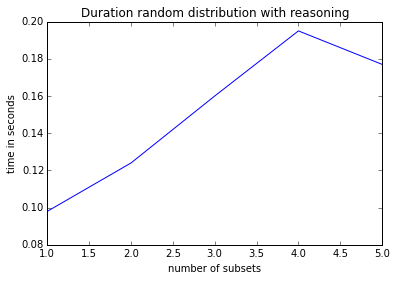

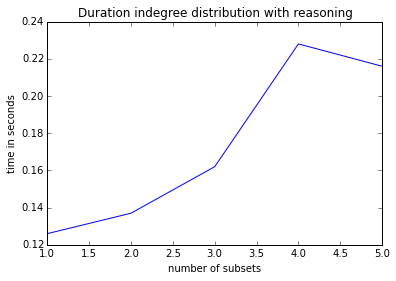

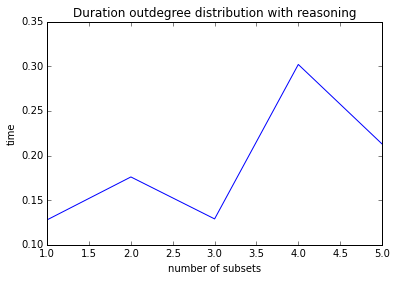

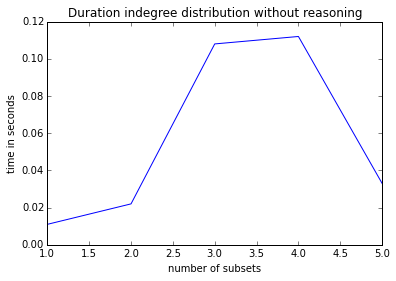

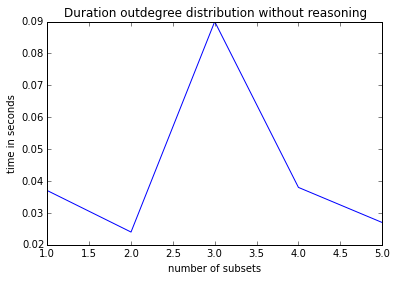

In [38]:
#time plot
plt.plot([1,2,3,4,5], time_random_true)
plt.title('Duration random distribution with reasoning')
plt.xlabel('number of subsets')
plt.ylabel('time in seconds')
plt.show()

plt.plot([1,2,3,4,5], time_in_true)
plt.title('Duration indegree distribution with reasoning')
plt.xlabel('number of subsets')
plt.ylabel('time in seconds')
plt.show()

plt.plot([1,2,3,4,5], time_out_true)
plt.title('Duration outdegree distribution with reasoning')
plt.xlabel('number of subsets')
plt.ylabel('time')
plt.show()

plt.plot([1,2,3,4,5], time_in_false)
plt.title('Duration indegree distribution without reasoning')
plt.xlabel('number of subsets')
plt.ylabel('time in seconds')
plt.show()

plt.plot([1,2,3,4,5], time_out_false)
plt.title('Duration outdegree distribution without reasoning')
plt.xlabel('number of subsets')
plt.ylabel('time in seconds')
plt.show()